In [4]:
#Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


data = pd.read_csv("covid2.csv",index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-10,44347.800781,45661.171875,43402.808594,43565.113281,43565.113281,32142048537
2022-02-11,43571.128906,43810.832031,42114.539063,42407.937500,42407.937500,26954925781
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,42244.468750,18152390304
2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,42197.515625,14741589015
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,42586.917969,20827783012
2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704


In [4]:
dropcol = ['Location ISO Code', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases', 'Location Level', 'City or Regency', 'Province', 'Country', 'Continent', 'Island', 'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 'Area (km2)', 'Population' , 'Population Density', 'Longitude', 'Latitude', 'New Cases per Million', 'Total Cases per Million', 'New Deaths per Million', 'Total Deaths per Million', 'Case Fatality Rate', 'Case Recovered Rate', 'Growth Factor of New Cases', 'Growth Factor of New Deaths']
data.drop(dropcol, axis=1, inplace= True)
data.head()

,Location,NewCases
Date,,
2020-03-01,DKI Jakarta,3
2020-03-01,Jawa Barat,3
2020-03-02,DKI Jakarta,2
2020-03-02,Indonesia,2
2020-03-02,Jawa Barat,0


In [5]:
indo = data[data.Location== 'Indonesia']
indo.tail(10)

,Location,NewCases
Date,,
2020-06-13,Indonesia,1014
2020-06-14,Indonesia,857
2020-06-15,Indonesia,1017
2020-06-16,Indonesia,1106
2020-06-17,Indonesia,1031
2020-06-18,Indonesia,1331
2020-06-19,Indonesia,1041
2020-06-20,Indonesia,1226
2020-06-21,Indonesia,862


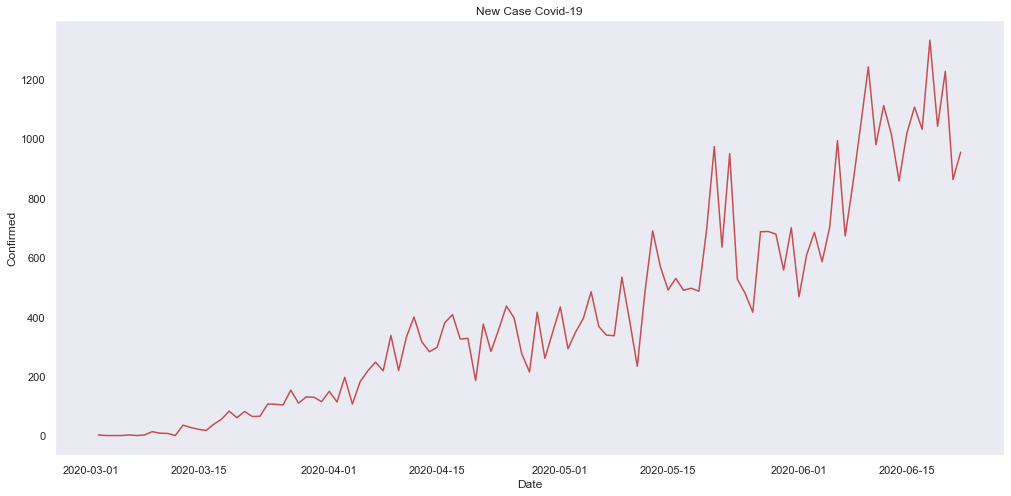

In [17]:
plt.figure(figsize=(17,8))
plt.plot(indo.NewCases,'r')
plt.title('New Case Covid-19')
plt.ylabel('Confirmed')
plt.xlabel('Date')
plt.grid(False)
plt.show()

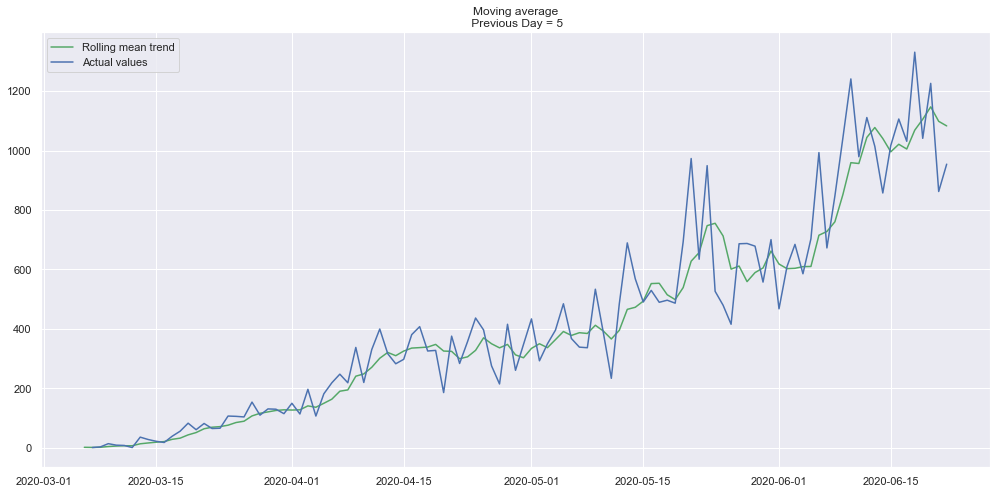

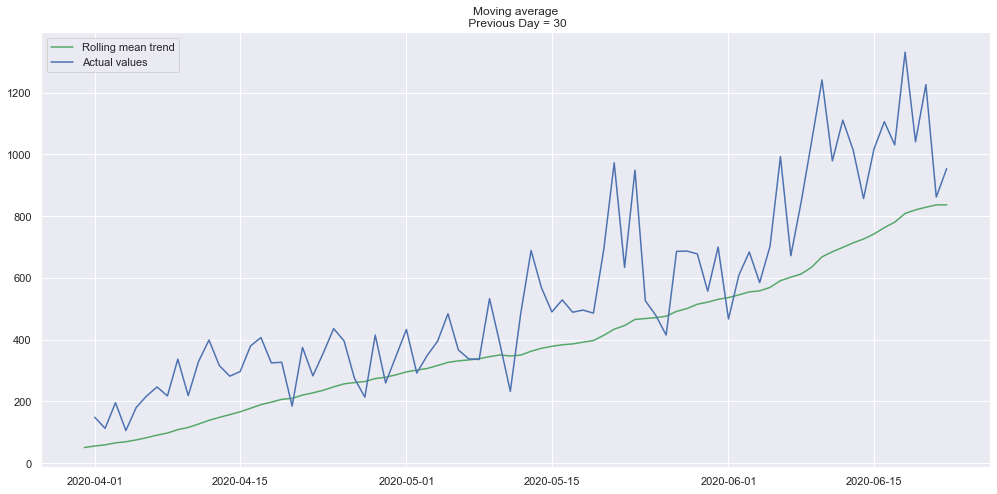

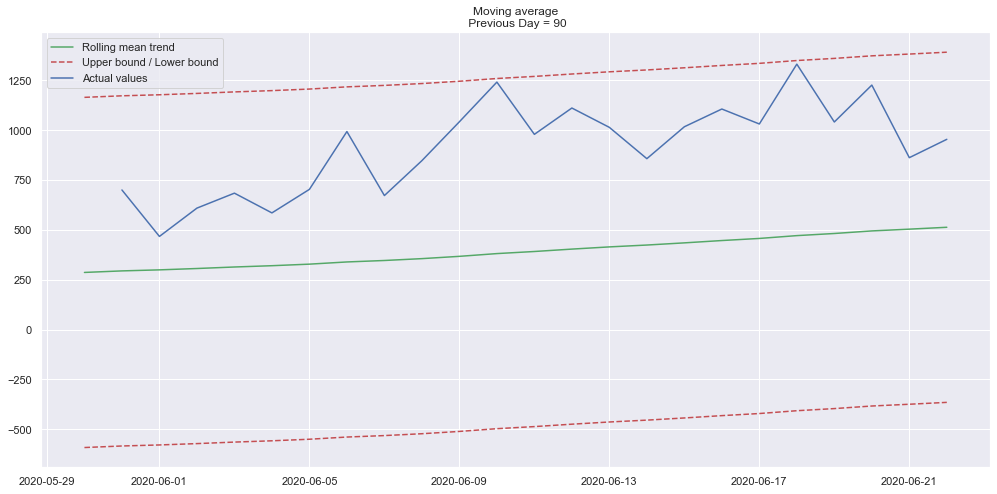

In [20]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n Previous Day = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
#Smooth by the previous 5 days (by week)
plot_moving_average(indo.NewCases, 5)

#Smooth by the previous month (30 days)
plot_moving_average(indo.NewCases, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(indo.NewCases, 90, plot_intervals=True)

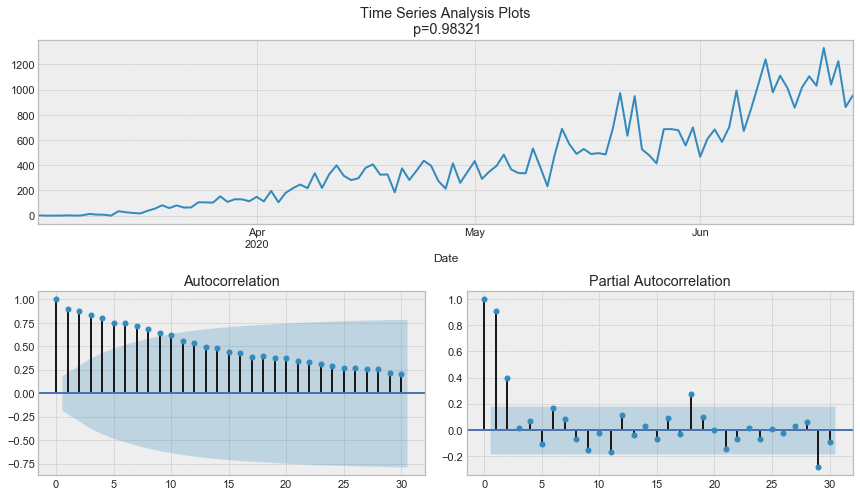

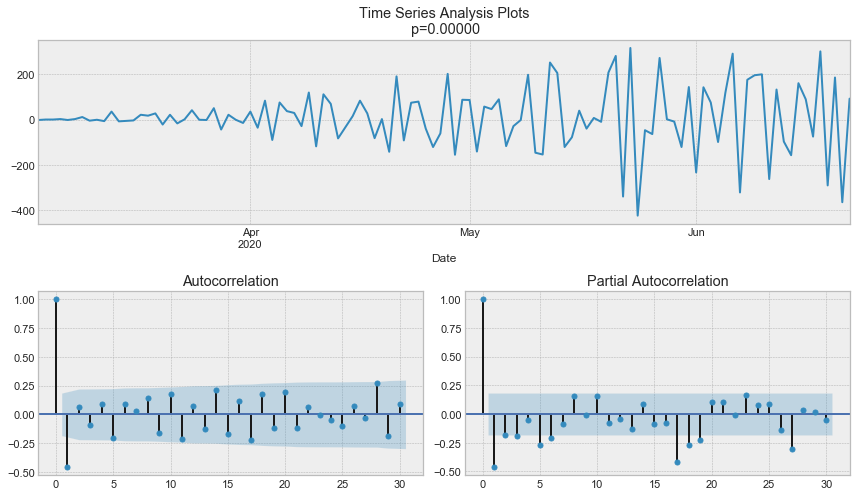

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(indo.NewCases, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = indo.NewCases - indo.NewCases.shift(1)

tsplot(data_diff[1:], lags=30)

In [9]:
#set range
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create list params
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train model with best combination params
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(indo.NewCases, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(indo.NewCases, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                          NewCases   No. Observations:                  113
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 5)   Log Likelihood                -657.247
Date:                           Tue, 08 Sep 2020   AIC                           1330.494
Time:                                   19:56:50   BIC                           1351.877
Sample:                               03-02-2020   HQIC                          1339.163
                                    - 06-22-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9575      0.089     10.712      0.000       0.782       1.133
ar.L2         -0.2575      0.103     -2.50

In [10]:
mse = best_model.mse
mae = best_model.mae
print(mse)
print(mae)

10569.99838952085
71.8032275290366


In [11]:
predicts = best_model.predict(start="2020-06-23", end="2020-06-28", dynamic=False)
for predict in predicts:
    print(int(predict),'Positive Case Per day')

950 Kasus per hari
1086 Kasus per hari
1154 Kasus per hari
1221 Kasus per hari
1212 Kasus per hari
1140 Kasus per hari


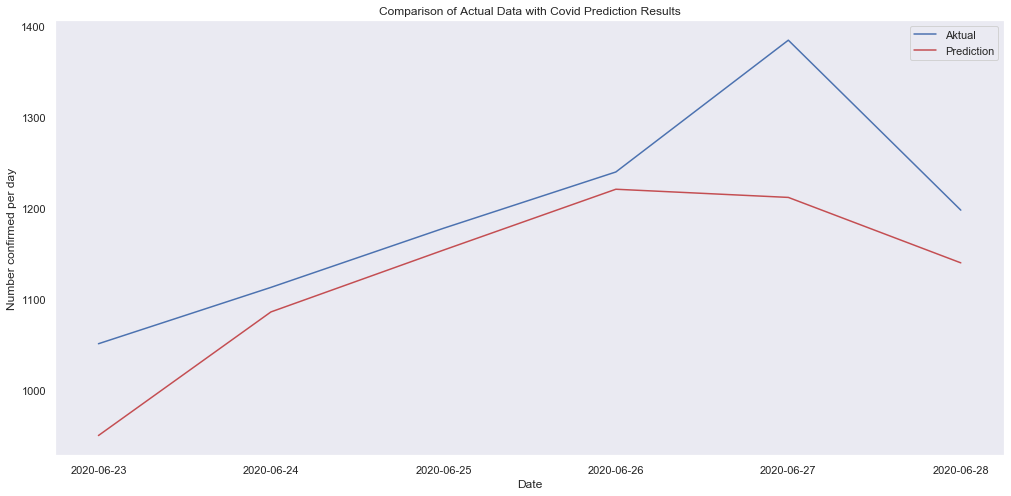

In [22]:
comparison = pd.DataFrame({'actual': [1051, 1113, 1178, 1240, 1385, 1198],
                          'predict': [950, 1086, 1154, 1221, 1212, 1140]}, 
                          index = pd.date_range(start='2020-06-23', periods=6,))


#Plot predicted vs actual price

plt.figure(figsize=(17, 8))
plt.plot(comparison.actual, label = 'Actual')
plt.plot(comparison.predict,'r', label = 'Prediction')
plt.title('Comparison of Actual Data with Covid Prediction Results')
plt.ylabel('Number confirmed per day')
plt.xlabel('Date')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [14]:
hasil = mean_absolute_percentage_error(comparison.actual,comparison.predict)
print('MAPE = ',hasil,'%')

MAPE =  5.489626320444313 %
